In [12]:
import pandas as pd 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np 
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns 
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import xgboost as xgb
from datetime import date
from statsmodels.stats.weightstats import ttest_ind
from scipy.stats import skew
from scipy import stats
from sklearn.preprocessing import power_transform

In [2]:
def model_perform(X_train,y_train, X_test, y_test, model, name, verbose = 0 ):
    # train 
    model.fit(X_train, y_train)

    # test 
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)


    if verbose == 1 :
        print(' MAE {} '.format(mean_absolute_error(y_pred_test,y_test)))
        print(' MSE {} '.format(mean_squared_error(y_pred_test,y_test)))
        print(' R2 {} '.format(r2_score(y_train,y_pred_train)))
    else : 
        pass 
    
    result = {}
    result['mae'] = np.round(mean_absolute_error(y_pred_test,y_test),5)
    result['mse'] = np.round(mean_squared_error(y_pred_test,y_test),5)
    result['R2'] = np.round(r2_score(y_train,y_pred_train),5)
    result['name'] = name
    result['feature_size'] = X_train.shape[1]
    result['train_size'] = X_train.shape[0]
    result['test_size'] = X_test.shape[0]

    return model, y_pred_test, y_pred_train, result 

def show_error_pattern(y_pred, y_test):
    result_test = pd.DataFrame()
    result_test['score'] = y_pred
    result_test['type'] = 'predict'
    result_test['idx'] = np.arange(result_test.shape[0])

    result_test2 = pd.DataFrame()
    result_test2['score'] = np.squeeze(y_test)
    result_test2['type'] = 'test'
    result_test2['idx'] = np.arange(result_test2.shape[0])

    df_result = pd.concat([result_test2,result_test])

    sns.lineplot(data=df_result, x="idx", y='score', hue="type")


def bulk_train(df_input, drop_column, target_column, dataset_name, verbose = 0):

    error_report = []
    model_dict = {}

    # scaled the values 
    features_columns = df_input.drop(drop_column,axis=1).columns
    features_columns = list(features_columns) + [target_column]
    scaler = MinMaxScaler()
    df_input_scale = pd.DataFrame(scaler.fit_transform(df_input[features_columns]), columns = features_columns)
    

    # split train and test 
    X_train, X_test, y_train, y_test = train_test_split(df_input_scale.drop(target_column, axis=1), df_input_scale[target_column], test_size=0.12, random_state=42)

    regr = RandomForestRegressor(random_state=0)
    model_regr, y_pred_test_regr, y_pred_train_regr, result_rf   = model_perform(X_train, y_train, X_test, y_test, regr, name='rf', verbose = verbose )
    error_report.append(result_rf)

    xgbr = XGBRegressor(random_state=0)
    model_xgbr, y_pred_test_xgbr, y_pred_train_xgbr, result_xgb  = model_perform(X_train, y_train, X_test, y_test, xgbr, name='xgb', verbose = verbose)
    error_report.append(result_xgb)

    # SVR 
    svr = SVR(kernel='poly')
    model_svr, y_pred_test_svr, y_pred_train_svr, result_svr  = model_perform(X_train, y_train, X_test, y_test, svr, name='svr',verbose = verbose)
    error_report.append(result_svr)

    model_dict['rf'] = model_regr
    model_dict['xgbr'] = result_xgb
    model_dict['svr'] = result_svr
    
    df_report = pd.DataFrame(error_report)
    df_report['dataset'] = dataset_name
    return  model_dict, df_report

# House prediction 

In [42]:
from sklearn.datasets import load_boston
X, y = load_boston(return_X_y=True)
col = ['crim','zn','indus','chas','nox','rm','age','dis','rad','tax','ptratio','b-100','lstat']
df = pd.DataFrame(X,columns=col)
df['med_v'] = y

df = df.sample(300)


scaler = MinMaxScaler()
df_input_scale = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)

X_train, X_test, y_train, y_test = train_test_split(df_input_scale.drop('med_v',axis=1), df_input_scale['med_v'], test_size=0.2, random_state=42)

rf_house = RandomForestRegressor(random_state=0)
model_regr, y_pred_test_regr, y_pred_train_regr, result_rf   = model_perform(X_train, y_train, X_test, y_test, rf_house, name='rf', verbose =1 )

df_residual_rf = pd.DataFrame()
df_residual_rf['target'] = y_test
df_residual_rf['pred'] = y_pred_test_regr
df_residual_rf['error'] = df_residual_rf['target'] - df_residual_rf['pred']
df_residual_rf['std_error'] = (df_residual_rf['error'] - df_residual_rf['error'].mean()) / df_residual_rf['error'].std()


 MAE 0.07678407407407402 
 MSE 0.014759941341563786 
 R2 0.9801438418180733 


## Statiscial regression analysis 

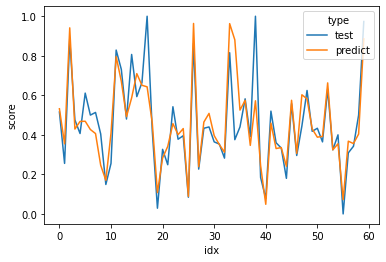

In [44]:
show_error_pattern(y_pred=y_pred_test_regr, y_test=y_test)

[Text(0.5, 1.0, 'coreelation between error and predicted -0.11039968152479')]

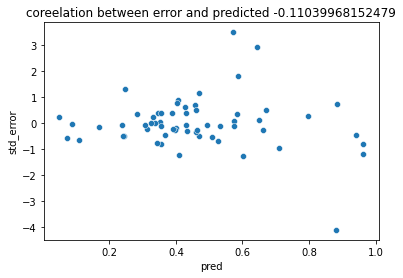

In [45]:
# examine predicted vs residual 
corr = stats.pearsonr(df_residual_rf['pred'],df_residual_rf['std_error'])[0]
sns.scatterplot(data=df_residual_rf, x="pred", y="std_error").set(title='coreelation between error and predicted {}'.format(corr)) 

[Text(0.5, 1.0, 'coreelation between actual and predicted 0.8509668126036336')]

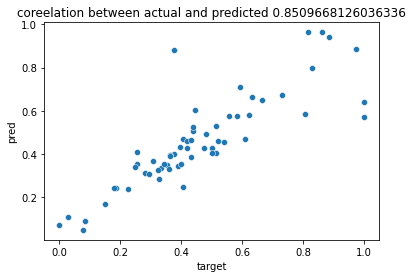

In [46]:
# correlation 
corr = stats.pearsonr(df_residual_rf['target'],df_residual_rf['pred'])[0]
sns.scatterplot(data=df_residual_rf, x="target", y="pred").set(title='coreelation between actual and predicted {}'.format(corr)) 

<AxesSubplot:title={'center':'error skewness from random forest 0.027'}, ylabel='Frequency'>

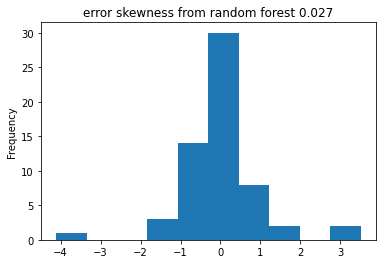

In [47]:
# plot error skewness 
title = 'error skewness from random forest {}'.format(np.round(skew(df_residual_rf['std_error']),3))
df_residual_rf['std_error'].plot(kind='hist', title = title)

# Zomato only 

In [13]:
# zomato only

df_zom = pd.read_csv('data/3_clean_zomato_feat.csv')
df_zom['rest_price_idr'] = df_zom['rest_price_idr'] / 1000
df_zom['rest_price_idr'] = df_zom['rest_price_idr'].astype(int)

# remove 0 rating 
df_zom = df_zom[df_zom['rating']>0]

drop_column = ['url','index','rating','lat','long','review','new_code_res_type','new_code_fac']
target_column = 'rating'

# scaled the values 
features_columns = df_zom.drop(drop_column,axis=1).columns
features_columns = list(features_columns) + [target_column]
scaler = MinMaxScaler()
df_input_scale = pd.DataFrame(scaler.fit_transform(df_zom[features_columns]), columns = features_columns)

#overwrite the rating with log transform 
# df_input_scale['rating'] =   np.log(df_zom[target_column])
# df_input_scale = df_input_scale.dropna()

#overwrite the rating with power  transform 
df_input_scale['rating'] = power_transform(df_zom['rating'].to_numpy().reshape(-1, 1), method='box-cox')
    

In [ ]:
df_zom['rating'].plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

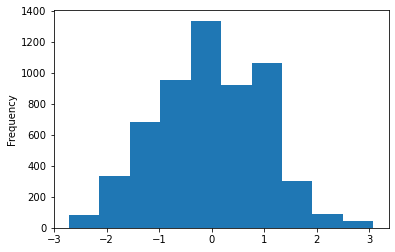

In [14]:
df_input_scale['rating'].plot(kind='hist')

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df_input_scale.drop(target_column, axis=1), df_input_scale[target_column], test_size=0.2, random_state=42)


 MAE 0.7658582050037178 
 MSE 0.9549508520878301 
 R2 0.811525318887661 


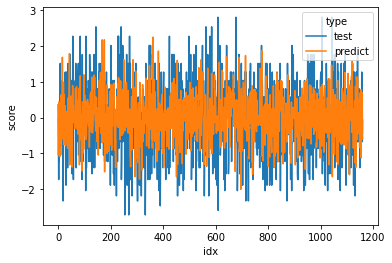

In [16]:
regr = RandomForestRegressor(random_state=0)
model_regr, y_pred_test_regr, y_pred_train_regr, result_rf   = model_perform(X_train, y_train, X_test, y_test, regr, name='rf', verbose =1 )
df_residual_rf = pd.DataFrame()
df_residual_rf['target'] = y_test
df_residual_rf['pred'] = y_pred_test_regr
df_residual_rf['error'] = df_residual_rf['target'] - df_residual_rf['pred']
df_residual_rf['std_error'] = (df_residual_rf['error'] - df_residual_rf['error'].mean()) / df_residual_rf['error'].std()

show_error_pattern(y_pred=y_pred_test_regr, y_test=y_test)

## Statistical regression analysis 

[Text(0.5, 1.0, 'correlation between error and predicted -0.2556368677498636')]

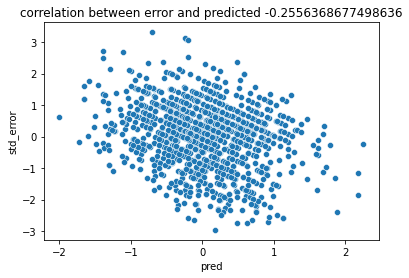

In [17]:
# examine predicted vs residual 
corr = stats.pearsonr(df_residual_rf['pred'],df_residual_rf['std_error'])[0]
sns.scatterplot(data=df_residual_rf, x="pred", y="std_error").set(title='correlation between error and predicted {}'.format(corr)) 

[Text(0.5, 1.0, 'coreelation between actual and predicted 0.3670475039040278')]

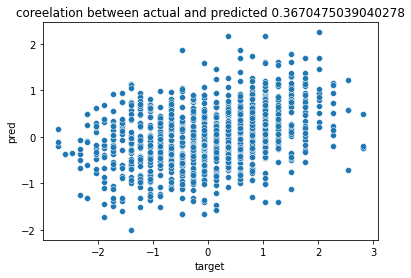

In [18]:
# correlation 
corr = stats.pearsonr(df_residual_rf['target'],df_residual_rf['pred'])[0]
sns.scatterplot(data=df_residual_rf, x="target", y="pred").set(title='coreelation between actual and predicted {}'.format(corr)) 

<AxesSubplot:title={'center':'error skewness from random forest -0.22'}, ylabel='Frequency'>

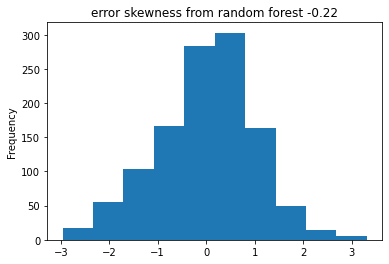

In [19]:
# plot error skewness 
title = 'error skewness from random forest {}'.format(np.round(skew(df_residual_rf['std_error']),3))
df_residual_rf['std_error'].plot(kind='hist', title = title)